Adapted from https://github.com/CSAILVision/semantic-segmentation-pytorch

In [0]:
!pip install yacs
!git clone https://github.com/CSAILVision/semantic-segmentation-pytorch.git
%cd semantic-segmentation-pytorch
!mkdir ade20k-resnet50dilated-ppm_deepsup
%cd ade20k-resnet50dilated-ppm_deepsup/
!wget http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth
!wget http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth

Cloning into 'semantic-segmentation-pytorch'...
remote: Enumerating objects: 1039, done.
remote: Total 1039 (delta 0), reused 0 (delta 0), pack-reused 1039
Receiving objects: 100% (1039/1039), 4.00 MiB | 7.03 MiB/s, done.
Resolving deltas: 100% (634/634), done.
/content/semantic-segmentation-pytorch/ade20k-resnet50dilated-ppm_deepsup/semantic-segmentation-pytorch/semantic-segmentation-pytorch/semantic-segmentation-pytorch
/content/semantic-segmentation-pytorch/ade20k-resnet50dilated-ppm_deepsup/semantic-segmentation-pytorch/semantic-segmentation-pytorch/semantic-segmentation-pytorch/ade20k-resnet50dilated-ppm_deepsup
--2020-06-03 03:37:43--  http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth
Resolving sceneparsing.csail.mit.edu (sceneparsing.csail.mit.edu)... 128.30.100.255
Connecting to sceneparsing.csail.mit.edu (sceneparsing.csail.mit.edu)|128.30.100.255|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1118

In [0]:
%cd ..

/content/semantic-segmentation-pytorch/ade20k-resnet50dilated-ppm_deepsup/semantic-segmentation-pytorch/semantic-segmentation-pytorch/semantic-segmentation-pytorch


In [0]:
import os
import sys

In [0]:
import os
import argparse
from distutils.version import LooseVersion
# Numerical libs
import numpy as np
import torch
import torch.nn as nn
from scipy.io import loadmat
import csv
# Our libs
from dataset import TestDataset
from models import ModelBuilder, SegmentationModule
from utils import colorEncode, find_recursive, setup_logger
from lib.nn import user_scattered_collate, async_copy_to
from lib.utils import as_numpy
from PIL import Image
from tqdm import tqdm
from config import cfg
from IPython.display import display

In [0]:
def visualize_result(data, pred, cfg):
    (img, info) = data

    # print predictions in descending order
    pred = np.int32(pred)
    pixs = pred.size
    uniques, counts = np.unique(pred, return_counts=True)
    print("Predictions in [{}]:".format(info))
    for idx in np.argsort(counts)[::-1]:
        name = names[uniques[idx] + 1]
        ratio = counts[idx] / pixs * 100
        if ratio > 0.1:
            print("  {}: {:.2f}%".format(name, ratio))

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(np.uint8)

    # aggregate images and save
    im_vis = np.concatenate((img, pred_color), axis=1)

    img_name = info.split('/')[-1]
    Image.fromarray(im_vis).save(
        os.path.join(cfg.TEST.result, img_name.replace('.jpg', '.png')))

In [0]:
image_url = 'https://images.homedepot-static.com/lifestyleimages/1024x682/ccc6ca8e-ea34-4ff5-b600-ddeb826ef892157.jpeg'  #@param {type:"string"}


In [0]:
image_file = 'shop_by_room.jpg'

In [0]:
import requests

img_data = requests.get(image_url).content
with open('shop_by_room.jpg', 'wb') as handler:
    handler.write(img_data)

In [0]:
args = argparse.Namespace(cfg='config/ade20k-resnet50dilated-ppm_deepsup.yaml', gpu=0, imgs='shop_by_room.jpg', opts=['DIR', 'ade20k-resnet50dilated-ppm_deepsup', 'TEST.result', './', 'TEST.checkpoint', 'epoch_20.pth'])

In [0]:
cfg.merge_from_file(args.cfg)
cfg.merge_from_list(args.opts)

In [0]:
cfg.MODEL.arch_encoder = cfg.MODEL.arch_encoder.lower()
cfg.MODEL.arch_decoder = cfg.MODEL.arch_decoder.lower()

# absolute paths of model weights
cfg.MODEL.weights_encoder = os.path.join(
    cfg.DIR, 'encoder_' + cfg.TEST.checkpoint)
cfg.MODEL.weights_decoder = os.path.join(
    cfg.DIR, 'decoder_' + cfg.TEST.checkpoint)

In [0]:
imgs = [args.imgs]
cfg.list_test = [{'fpath_img': x} for x in imgs]

In [0]:
torch.cuda.set_device(args.gpu)

# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch=cfg.MODEL.arch_encoder,
    fc_dim=cfg.MODEL.fc_dim,
    weights=cfg.MODEL.weights_encoder)
net_decoder = ModelBuilder.build_decoder(
    arch=cfg.MODEL.arch_decoder,
    fc_dim=cfg.MODEL.fc_dim,
    num_class=cfg.DATASET.num_class,
    weights=cfg.MODEL.weights_decoder,
    use_softmax=True)

crit = nn.NLLLoss(ignore_index=-1)

segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)

Loading weights for net_encoder
Loading weights for net_decoder


In [0]:
dataset_test = TestDataset(
        cfg.list_test,
        cfg.DATASET)

loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=cfg.TEST.batch_size,
        shuffle=False,
        collate_fn=user_scattered_collate,
        num_workers=5,
        drop_last=True)

segmentation_module.cuda()

# samples: 1


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

In [0]:
gpu = args.gpu
loader = loader_test

segmentation_module.eval()

pbar = tqdm(total=len(loader))
for batch_data in loader:
    # process data
    batch_data = batch_data[0]
    segSize = (batch_data['img_ori'].shape[0],
               batch_data['img_ori'].shape[1])
    img_resized_list = batch_data['img_data']

    with torch.no_grad():
        scores = torch.zeros(1, cfg.DATASET.num_class, segSize[0], segSize[1])
        scores = async_copy_to(scores, gpu)

        for img in img_resized_list:
            feed_dict = batch_data.copy()
            feed_dict['img_data'] = img
            del feed_dict['img_ori']
            del feed_dict['info']
            feed_dict = async_copy_to(feed_dict, gpu)

            # forward pass
            pred_tmp = segmentation_module(feed_dict, segSize=segSize)
            scores = scores + pred_tmp / len(cfg.DATASET.imgSizes)

        _, pred = torch.max(scores, dim=1)
        pred = as_numpy(pred.squeeze(0).cpu())




  0%|          | 0/1 [00:00<?, ?it/s]

In [0]:
colors = loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

In [0]:
visualize_result(
            (batch_data['img_ori'], batch_data['info']),
            pred,
            cfg
        )


Predictions in [shop_by_room.jpg]:
  wall: 58.08%
  floor: 15.11%
  toilet: 5.89%
  cabinet: 4.40%
  windowpane: 3.54%
  mirror: 3.26%
  bathtub: 2.85%
  curtain: 2.54%
  painting: 1.61%
  rug: 1.48%
  shelf: 0.48%
  ashcan: 0.40%
  sconce: 0.34%


In [0]:
pred = np.int32(pred)

In [0]:
(img, info) = (batch_data['img_ori'], batch_data['info'])

pred_color = colorEncode(pred, colors).astype(np.uint8)

# aggregate images and save
im_vis = np.concatenate((img, pred_color), axis=1)

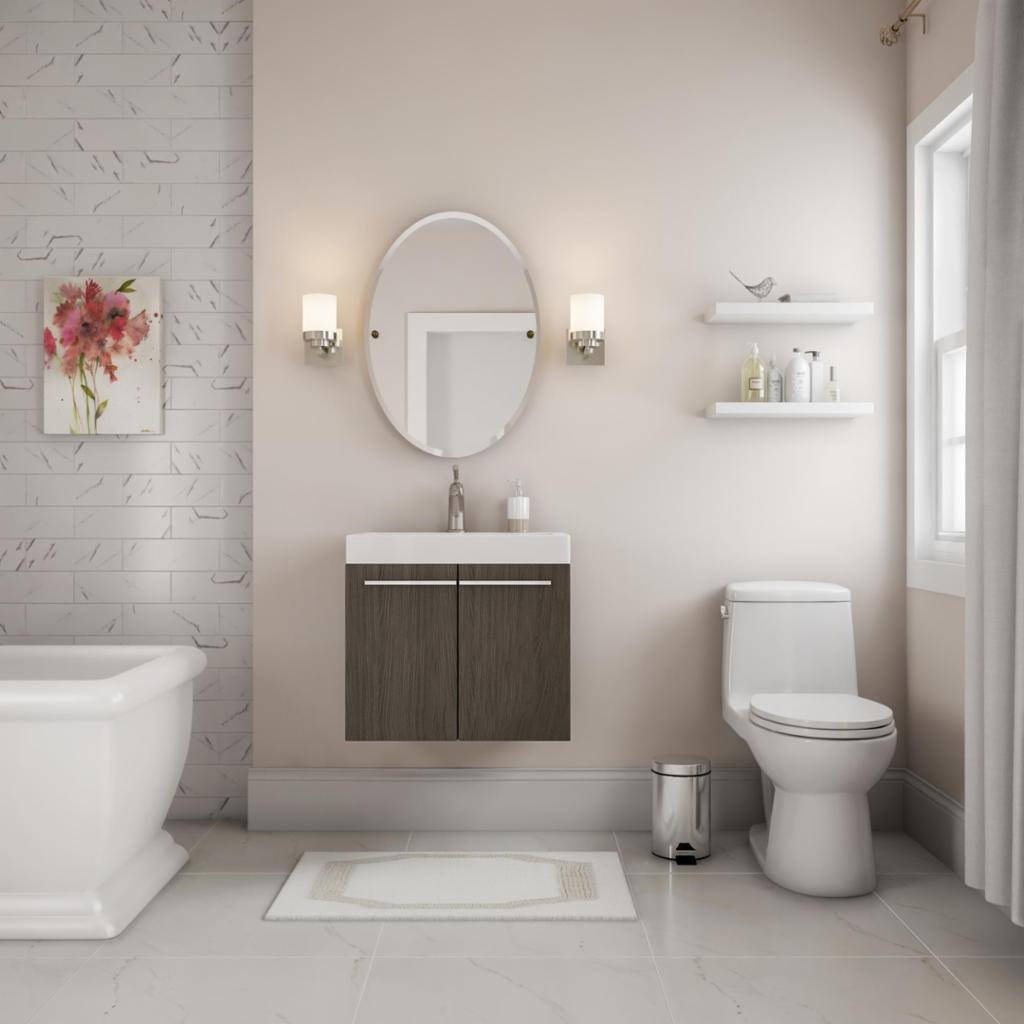

In [0]:
display(Image.open('shop_by_room.jpg'))

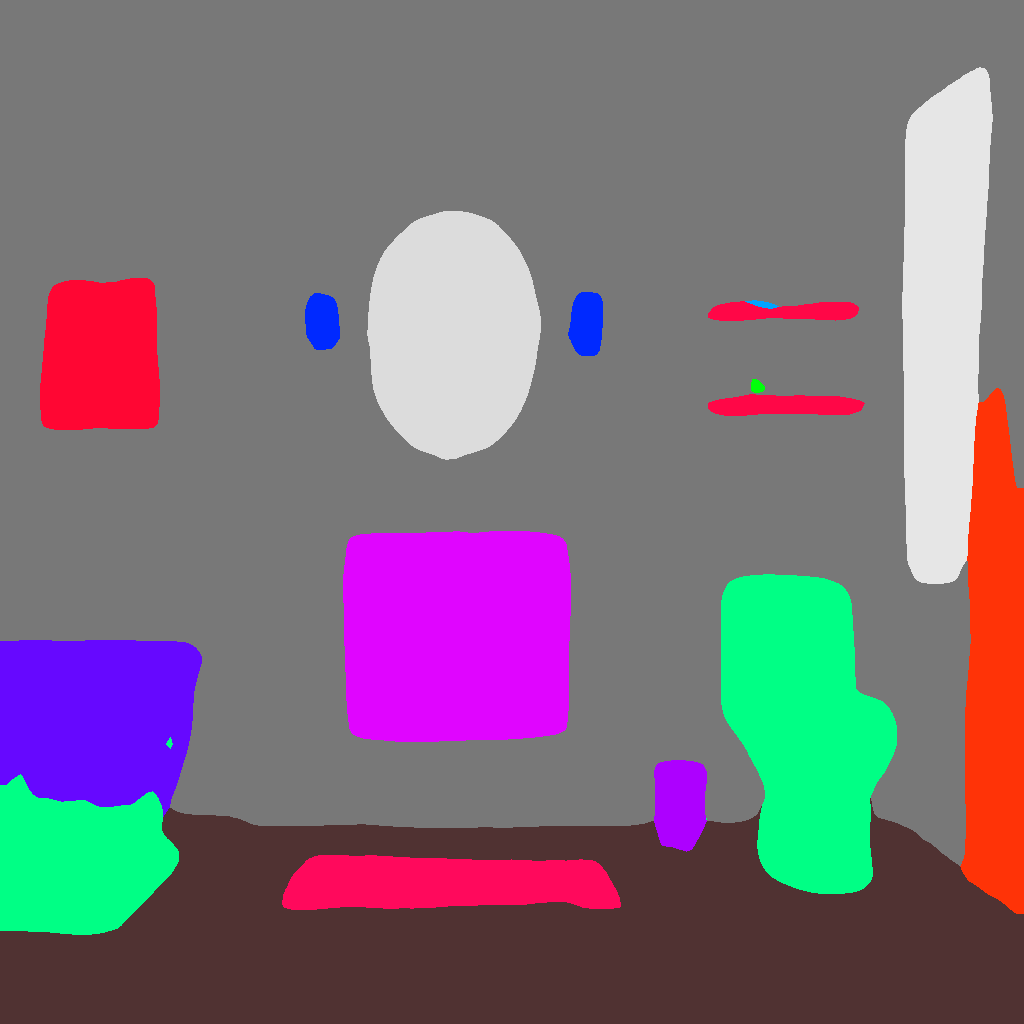

In [0]:
display(Image.fromarray(pred_color))

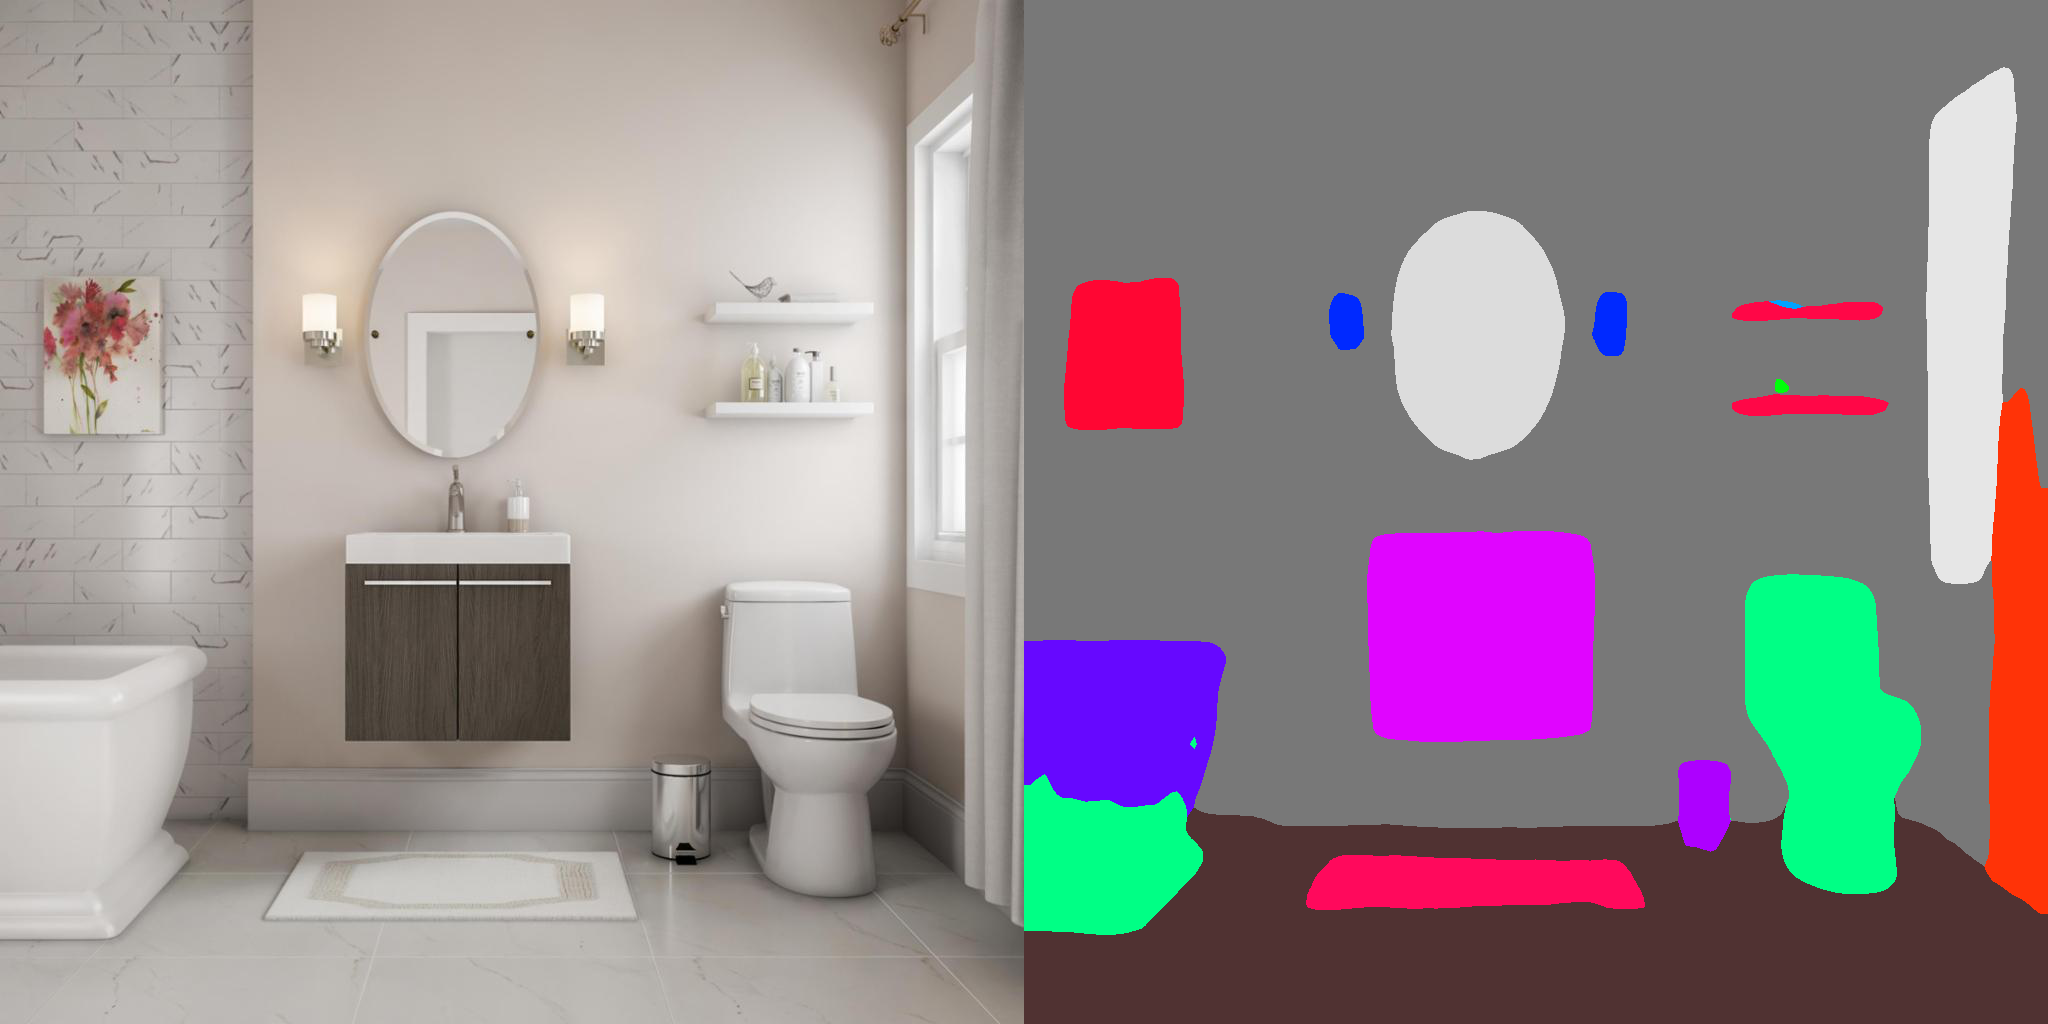

In [0]:
display(Image.fromarray(im_vis))